# Fake News Classification

----------------------

![Banner ](https://raw.githubusercontent.com/SauravMaheshkar/Fake-News-Classification/master/Banner.png)

We have all seen fake news forwards on our WhatsApp messages. Generally, these articles are generated by bots and internet trollers and are used with an intent to intrigue the audience and mislead them. Fake news can be very dangerous as it can spread misinformation and inflict rage in public. It is now becoming a serious problem in India due to more and more people using social media and lower levels of digital awareness.

This Notebook is a part of a series of notebooks, in which I explore different Methods of Classifying Fake News using a variety of Algorithms. You can find the other notebooks on my [profile page](https://www.kaggle.com/sauravmaheshkar). If you're interested in viewing a demo of this Classifier, you can visit my [Github repository](https://github.com/SauravMaheshkar/Fake-News-Classification). 

# Importing Packages
-------------------

Here, we import the basic packages like pandas and numpy for I/O and Linear Algebra. Link to the documentation of the packages can be found here:

* [numpy](https://numpy.org/)
* [pandas](https://pandas.pydata.org/)
* [os](https://docs.python.org/3/library/os.html)
* [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)
* [matlplotlib](https://matplotlib.org/)
* [seaborn](https://seaborn.pydata.org/)

In [1]:
import numpy as np # For Linear Algebra
import pandas as pd # For I/O, Data Transformation
import os # For Elementary OS operations
from sklearn.metrics import precision_recall_fscore_support as score # For Evaluating the Model
from sklearn.metrics import accuracy_score as acs # For Evaluating the Model
import matplotlib.pyplot as plt # For Plotting
import seaborn as sns # For Plotting
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# Pre-Processing

--------------------------

We perform the following operations for pre-processing the data:

* Reducing the corpus size to only 5000 per class (Kaggle Kernels couldn't handle the full data 😅)
* Adding a "Class"variable to the records. "0" for Fake News and "1" for Real News
* Concatenating the "Title" and "Text" Column and Removing other redundant classes like "Subject" and "Date"
* Creating a Single Dataframe by Concatenating both the Dataframes together
* Removing the original dataframe

In [2]:
## Creating Individual Data Frames
fakedataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv") # Make a DataFrame for Fake News
realdataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv") # Make a DataFrame for Real News

## Reducing Corpus Size
fakedataset = fakedataset[:5000] 
realdataset = realdataset[:5000] 

## Adding Classes
realdataset["class"] = 1 # Adding Class to Real News
fakedataset["class"] = 0 # Adding Class to Fake News

## Concatenating 'Title' and 'Text' together
realdataset["text"] = realdataset["title"] + " " + realdataset["text"] # Concatenating Text and Title into a single column for Real News DataFrame
fakedataset["text"] = fakedataset["title"] + " " + fakedataset["text"] # Concatenating Text and Title into a single column for Fake News DataFrame

## Removing Redundant Columns
realdataset = realdataset.drop(["subject", "date", "title"], axis = 1) # Removing Redundant features from Real News DataFrame
fakedataset = fakedataset.drop(["subject", "date", "title"], axis = 1) # Removing Redundant features from Fake News DataFrame

## Appending the DataFrames together
dataset = realdataset.append(fakedataset, ignore_index = True) # Making a Single DataFrame 

## Deleting the other dataframes
del realdataset, fakedataset 

Let's see the final processed format of our corpus

In [3]:
dataset.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


# nltk Downloads
-----------------
Here, we import [nltk](https://www.nltk.org/) (Natural Language Toolkit) and download the stopwords and punkt package

![nltk logo](https://image.slidesharecdn.com/nltkatoolfornlp-pycon-dhaka-2014-140622215544-phpapp02/95/nltka-tool-fornlp-pycondhaka2014-1-638.jpg?cb=1403474175)

In [4]:
import nltk

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Stemming and Removal of Punctuation and Stopwords
------------

Here, we use:

* [re](https://docs.python.org/3/library/re.html) module
* [string](https://docs.python.org/2/library/string.html) module
* [PorterStemmer](https://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter) from ```nltk.stem``` module

To remove punctuations and stopwords from the corpus

In [5]:
## Import Statements
import re
import string
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.PorterStemmer()

## Functions, which counts number of punctuations
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100


## Adding 'Body Length' and 'Punct' to the dataframe
dataset['body_len'] = dataset['text'].apply(lambda x: len(x) - x.count(" "))
dataset['punct%'] = dataset['text'].apply(lambda x: count_punct(x))

## Cleaning the Text from Punctuations and Stopwords
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [stemmer.stem(word) for word in tokens if word not in stopwords]
    return text

Let's see the processed dataset

In [6]:
dataset.head()

,text,class,body_len,punct%
0,"As U.S. budget fight looms, Republicans flip t...",1,3962,3.1
1,U.S. military to accept transgender recruits o...,1,3509,2.3
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1,2375,2.2
3,FBI Russia probe helped by Australian diplomat...,1,2136,2.5
4,Trump wants Postal Service to charge 'much mor...,1,4400,3.1


# Splitting the Dataset
------------
Here, we use the ```train_test_split()``` function from [sklearn.model_prediction](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split our supervised dataset into Test and Train Subsets.

In [7]:
## Import Statements
from sklearn.model_selection import train_test_split

## Choosing Columns from dataset as X(Input) and y(Label)
X=dataset[['text', 'body_len', 'punct%']]
y=dataset['class']

## Using train_test_split to split our dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)

# Vectorising the Corpus
----------------
Here, we use the ```TfidfVectoriser``` from [sklearn.feature_extraction](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) to vectorise the corpus 

In [8]:
## Import Statements
from sklearn.feature_extraction.text import TfidfVectorizer

## Declaring a Vectoriser
tfidf_vect = TfidfVectorizer(analyzer=clean_text)

## 'Fitting' the Vectoriser
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

## Creating 'Test' and 'Train' vectorised dataframes
tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])

## Adding 'Body_Len' and 'punct' columns to the front
X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

## Checking, if we did everything alright
X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,55054,55055,55056,55057,55058,55059,55060,55061,55062,55063
0,1766,1.8,0.014404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2928,2.7,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2249,2.0,0.010530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3483,1.9,0.005983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,338,2.1,0.028734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training the Model
--------

Here, we create a instance of the ```DecisionTreeClassifier()``` from [sklearn.tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) and train it on the corpus.

Then, we evaluate the model on our 'Test' Subset and plot the Confusion Matrix using [```sklearn.metrics.confusion_matrix```](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) and seaborn.

Precision: 0.996 / Recall: 0.997 / F1-Score: 0.997 / Accuracy: 0.996


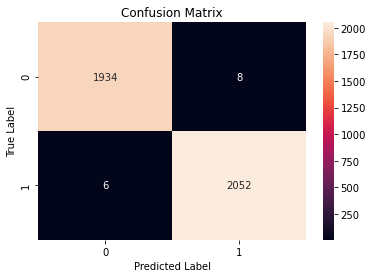

In [9]:
## Import Statements
from sklearn.tree import DecisionTreeClassifier

## Instantiating a DecisionTreeClassifier
clf = DecisionTreeClassifier()

## 'Training' the Classifier
clf = clf.fit(X_train_vect,y_train)

## Predicting with the Classifier
y_pred = clf.predict(X_test_vect)

## Evaluating the Model against it's predictions
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred), 3)))

## Making the Confusion Matrix

### Import Statements
from sklearn.metrics import confusion_matrix

### Creating a confusion_matrix instance 
cm = confusion_matrix(y_test, y_pred)

### Making a Dataframe, of the metrics with classes
class_label = [0, 1]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)

### Plotting the Model
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Thanks, for viewing this Notebook, Kindly view my other notebooks on Fake News Classification on my [profile](https://www.kaggle.com/sauravmaheshkarv)**